# Echo State Network
Here, we validate the hyperparameters of the ESN. Note that the ESN is only trained on the encoded latent space representation. 

In [9]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from neuralnetwork.autoencoder import CAE
from neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split

sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers

#### 1: Load the trained CAE and the encoded time series

In [2]:
cae_path = Path('../weights/fluent-sweep-2/')
with open(cae_path/'ks.json') as f:
    ks_data = json.load(f)
print(ks_data)

with open(cae_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)
print(f"Encoded timeseries {U_encoded.shape}")

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.005, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.04}
Encoded timeseries (499751, 8)


#### 2: Prepare the encoded data for the ESN training

In [3]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)

In [4]:
total_samples, dim = u_encoded_train.shape
N_washout = 200
train_size = min(len(u_encoded_train)-N_washout-101, 100000)#-1001
val_size = min(len(u_encoded_valid)-101-N_washout, 20001)
test_N_washout = 100
# Split the data into different datasets
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout:N_washout+train_size-1, ...]
U_train_label = u_encoded_train[N_washout + 1:N_washout+train_size, ...]
U_val_input = u_encoded_valid[:val_size-1, ...]
U_val_label = u_encoded_valid[1:val_size, ...]
U_test_washout = u_encoded_test[:test_N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]
# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape, U_train_label.shape}")
print(f"U_val shape: {U_val_input.shape, U_val_label.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: ((99999, 8), (99999, 8))
U_val shape: ((20000, 8), (20000, 8))
U_test shape: (139551, 8)


#### 3: Validate the hyperparameters of the ESN

In [5]:
#  specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
hyperparameter_dict = {
    'spectral_radius': [0.1, 1.0, 'uniform'],
    'input_scaling': [0.01, 10.0, 'log10'],
    'tikhonov': [1e-12, 1e-3, 'log10'],
    # 'leak_factor': [0.1, 1.0, 'uniform']  # Uncomment if needed
}
grid_range = []
for i, parameter in enumerate(hyperparameter_dict.keys()):
    scaler = getattr(scalers, hyperparameter_dict[parameter][-1])
    grid_range.append(scaler(hyperparameter_dict[parameter][:2]))

# compute normalization factor (range component-wise)
U_data = U_esn[:N_washout+train_size, :dim].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

N_val = 1000  # number of validation steps

# fixed properties of the ESN
ESN_dict = {'reservoir_size': 1000,
        'dimension': dim,
        'reservoir_connectivity': 10,
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]),
        'input_bias': np.array([1]),
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]*2),
        'output_bias':  np.array([1]),
        'reservoir_weights_mode': "erdos_renyi1",
        # 'tikhonov': 1e-10,
        'input_normalization': [u_mean, norm],
        # 'input_weights_mode': 'dense',
        'input_seeds':[0, 1, 2],
        'reservoir_seeds':[3, 4]
    }


min_dict = validate(
    grid_range=grid_range,
    param_names=[key for key in hyperparameter_dict.keys()],
    param_scales=[values[-1] for values in hyperparameter_dict.values()],
    n_calls=20,  # number of total trials
    n_initial_points=10,  # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict,
    U_washout_train=U_washout,
    n_realisations=1,  # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label,
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=5,  # number of folds, i.e., validation time series that start from random time instances
    N_washout_steps=N_washout,
    N_val_steps=N_val,
    random_seed=10,  # random seed for the bayesian optimization
    error_measure=errors.rel_L2)  # error measure to optimize over

esn_loaded_dict = dict(min_dict, **ESN_dict)

Input to run_gp:([Real(low=0.1, high=1.0, prior='uniform', transform='identity'), Real(low=-2.0, high=1.0, prior='uniform', transform='identity'), Integer(low=-12.0, high=-3.0, prior='uniform', transform='identity')], 20, 10, 10)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6335601564025166
input_scaling 3.41033659841376
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  1.1596322281368523
Fold: 1 , fold error:  1.1046236364557438
Fold: 2 , fold error:  1.2303785887223146
Fold: 3 , fold error:  1.360967353600783
Fold: 4 , fold error:  1.2872792835717732
Val regime error: 1.2285762180974933
Realisation error: 1.2285762180974933


Run 1 error: 1.2285762180974933


--NEW RUN-- 2
Realisation: 0
spectral_radius 0.8625265649057131
input_scaling 0.7424908231815013
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  1.0335240433680222
Fold: 1 , fold error:  1.141708611767292
Fold: 2 , fold error:  0.8976432916716668
Fold: 3 , fold error:  0.92316038296367

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.67618e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.8260481599220946
Fold: 1 , fold error:  0.9055230666985729
Fold: 2 , fold error:  0.9260211209236785
Fold: 3 , fold error:  0.9542473042371856
Fold: 4 , fold error:  0.8693359673500619
Val regime error: 0.8962351238263186
Realisation error: 0.8962351238263186


Run 3 error: 0.8962351238263186


--NEW RUN-- 4
Realisation: 0
spectral_radius 0.529898605589215
input_scaling 2.732160361977424
tikhonov 1e-08


Val regime: 0
Fold: 0 , fold error:  1.2334692460533163
Fold: 1 , fold error:  1.0587240967083984
Fold: 2 , fold error:  0.9537418988020373
Fold: 3 , fold error:  1.0592206597960854
Fold: 4 , fold error:  1.1286204554779395
Val regime error: 1.0867552713675555
Realisation error: 1.0867552713675555


Run 4 error: 1.0867552713675555


--NEW RUN-- 5
Realisation: 0
spectral_radius 0.4535063164907469
input_scaling 3.2228217847874103
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  1.066046832775913
Fold: 1 , fold error:  1.14662830

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.56206e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.8237056600126818
Fold: 1 , fold error:  1.1167257527442553
Fold: 2 , fold error:  1.0518191977758535
Fold: 3 , fold error:  0.8978115224241089
Fold: 4 , fold error:  1.1829374209920953
Val regime error: 1.014599910789799
Realisation error: 1.014599910789799


Run 12 error: 1.014599910789799


--NEW RUN-- 13
Realisation: 0
spectral_radius 0.7681066321878792
input_scaling 3.5887791020195055
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  1.1897316419025965
Fold: 1 , fold error:  1.0774552097095362
Fold: 2 , fold error:  1.19760064753711
Fold: 3 , fold error:  1.2794456936461005
Fold: 4 , fold error:  1.1694431119760085
Val regime error: 1.1827352609542703
Realisation error: 1.1827352609542703


Run 13 error: 1.1827352609542703


--NEW RUN-- 14
Realisation: 0
spectral_radius 0.8304695570014251
input_scaling 0.019181568818764434
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  0.8489163056181256
Fold: 1 , fold error:  0.8880

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.9589e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.1034917279736103
Fold: 1 , fold error:  1.188896770912585
Fold: 2 , fold error:  0.9910170725176953
Fold: 3 , fold error:  0.8156360127449946
Fold: 4 , fold error:  0.9797718305688459
Val regime error: 1.0157626829435462
Realisation error: 1.0157626829435462


Run 16 error: 1.0157626829435462


--NEW RUN-- 17
Realisation: 0
spectral_radius 0.7400019788357671
input_scaling 0.012422592003676337
tikhonov 1e-07


Val regime: 0
Fold: 0 , fold error:  0.9093703953197269
Fold: 1 , fold error:  0.8970567236941512
Fold: 2 , fold error:  0.84811675921472
Fold: 3 , fold error:  0.8545968396783508
Fold: 4 , fold error:  0.9290474176268224
Val regime error: 0.8876376271067542
Realisation error: 0.8876376271067542


Run 17 error: 0.8876376271067542


--NEW RUN-- 18
Realisation: 0
spectral_radius 0.6452392070844719
input_scaling 5.85095651360072
tikhonov 0.001


Val regime: 0
Fold: 0 , fold error:  1.0961954778894916
Fold: 1 , fold error:  1.2905957107626742
Fol

#### 4: Select the best ESN hyperparameters
We provide hyperparameters from the ESN that we validated. 

In [6]:
with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
    esn_loaded_dict = pickle.load(f)

print(f"Dictionary loaded in {esn_loaded_dict}")
i=0
my_ESN = ESN(reservoir_size=esn_loaded_dict["reservoir_size"],
                dimension=esn_loaded_dict["dimension"],
                reservoir_connectivity=esn_loaded_dict["reservoir_connectivity"],
                spectral_radius=esn_loaded_dict['spectral_radius'][i],
                input_scaling=esn_loaded_dict['input_scaling'][i],
                tikhonov=esn_loaded_dict['tikhonov'][i],
                input_bias=esn_loaded_dict["input_bias"],
                output_bias=esn_loaded_dict["output_bias"],
                reservoir_weights_mode=esn_loaded_dict['reservoir_weights_mode'],
                input_normalization=esn_loaded_dict['input_normalization'],
                # input_weights_mode=esn_loaded_dict['input_weights_mode'],
                #   leak_factor =min_dict['leak_factor'][i],
                input_seeds=esn_loaded_dict["input_seeds"],
                reservoir_seeds=esn_loaded_dict["reservoir_seeds"], verbose=False)
my_ESN.train(U_washout, U_train_input, U_train_label)

Dictionary loaded in {'reservoir_size': 5000, 'dimension': 8, 'reservoir_connectivity': 10, 'input_bias': array([1]), 'output_bias': array([1]), 'reservoir_weights_mode': 'erdos_renyi1', 'input_normalization': [array([ 0.04632736, -0.0202649 , -0.08058597, -0.04703639, -0.14330693,
       -0.03961901, -0.03926516, -0.14617444]), array([0.78222102, 0.80043198, 0.84137316, 0.76709582, 0.69758855,
       0.7997398 , 0.728731  , 0.70858355])], 'input_weights_mode': 'dense', 'input_seeds': [0, 1, 2], 'reservoir_seeds': [3, 4], 'f': array([0.36003981, 0.40722199, 0.42022049, 0.45035164, 0.4855863 ]), 'spectral_radius': array([0.80881943, 0.82161872, 0.79331233, 0.79900527, 0.67501252]), 'input_scaling': array([0.0946024 , 0.09639518, 0.09498936, 0.09443689, 0.09481721]), 'tikhonov': array([1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10])}


/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16252e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


#### 5: CAE-ESN prediction on the test data

In [7]:
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(cae_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)

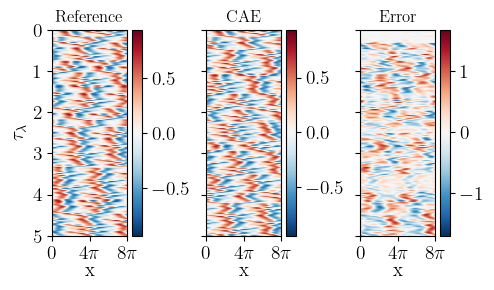

In [8]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/(ks_data["dt"]*ks_data["upsample"]))
N_plot = 5*N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length
domain_length = 20 * np.pi

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

N_start = 200 
reservoir, prediction = my_ESN.closed_loop_with_washout(u_encoded_test[N_start:N_start+N_washout, :dim], 15000)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+15000, :dim]).float().to(device)).numpy(force=True)


# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"]*ks_data["upsample"]))
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=fs)

axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
# plt.savefig("../images/cae-esn.png", dpi=100)
